# Model Building

In [80]:
# =============================================================================
# IMPORTS (for modeling.ipynb)
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nba_api.stats.endpoints import playergamelog, leaguedashteamstats
import time
from nba_api.stats.static import players

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import warnings
warnings.filterwarnings('ignore')

print("Imports loaded ✓")

Imports loaded ✓


In [81]:
# Load featured data
df = pd.read_csv("data/processed/player_game_logs_featured.csv")

print(f"Loaded {len(df)} games")
print(f"Columns: {df.columns.tolist()}")

Loaded 1980 games
Columns: ['SEASON_ID', 'Player_ID', 'Game_ID', 'GAME_DATE', 'MATCHUP', 'WL', 'MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'PLUS_MINUS', 'VIDEO_AVAILABLE', 'SEASON', 'HOME', 'REST_DAYS', 'B2B', 'PLAYER_NAME', 'ROLL_PTS_3', 'ROLL_PTS_5', 'ROLL_PTS_10', 'SEASON_AVG_PTS', 'PLAYER_AVG_PTS', 'OPPONENT', 'OPP_DEF_RATING']


### Define Features and Target

In [82]:
# Define feature columns
feature_cols = [
    'HOME',
    'REST_DAYS',
    'B2B',
    'ROLL_PTS_3',
    'ROLL_PTS_5',
    'ROLL_PTS_10',
    'SEASON_AVG_PTS'
]

# Target column
target_col = 'PTS'

# Create X (features) and y (target)
X = df[feature_cols]
y = df[target_col]

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nFeatures:\n{X.head()}")

Features shape: (1980, 7)
Target shape: (1980,)

Features:
   HOME  REST_DAYS  B2B  ROLL_PTS_3  ROLL_PTS_5  ROLL_PTS_10  SEASON_AVG_PTS
0     1        7.0    0   27.927273   27.927273    27.927273       27.927273
1     0        7.0    0   32.349593   32.349593    32.349593       32.349593
2     0        7.0    0   26.132653   26.132653    26.132653       26.132653
3     1        7.0    0   26.610000   26.610000    26.610000       26.610000
4     1        7.0    0   27.418478   27.418478    27.418478       27.418478


### Train/Test Split

In [83]:
# Sort by date to ensure chronological order
df = df.sort_values('GAME_DATE').reset_index(drop=True)

# Recreate X and y after sorting
X = df[feature_cols]
y = df[target_col]

# Use last 20% of games as test set (most recent games)
split_index = int(len(df) * 0.8)

X_train = X.iloc[:split_index]
X_test = X.iloc[split_index:]
y_train = y.iloc[:split_index]
y_test = y.iloc[split_index:]

print(f"Training set: {len(X_train)} games")
print(f"Test set: {len(X_test)} games")
print(f"\nTraining period: {df['GAME_DATE'].iloc[0]} to {df['GAME_DATE'].iloc[split_index-1]}")
print(f"Test period: {df['GAME_DATE'].iloc[split_index]} to {df['GAME_DATE'].iloc[-1]}")

Training set: 1584 games
Test set: 396 games

Training period: 2022-10-18 to 2024-12-27
Test period: 2024-12-27 to 2025-04-13


### Baseline Model-- Linear Regression

In [84]:
# Train Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Make predictions
y_pred_lr = lr_model.predict(X_test)

# Evaluate
mae_lr = mean_absolute_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2_lr = r2_score(y_test, y_pred_lr)

print("=== LINEAR REGRESSION RESULTS ===")
print(f"MAE:  {mae_lr:.2f} points")
print(f"RMSE: {rmse_lr:.2f} points")
print(f"R²:   {r2_lr:.3f}")

=== LINEAR REGRESSION RESULTS ===
MAE:  6.70 points
RMSE: 8.53 points
R²:   0.035


### Check Feature Importance

In [85]:
# See which features matter most
coefficients = pd.DataFrame({
    'Feature': feature_cols,
    'Coefficient': lr_model.coef_
}).sort_values('Coefficient', key=abs, ascending=False)

print("=== FEATURE IMPORTANCE (Linear Regression) ===")
print(coefficients)
print(f"\nIntercept: {lr_model.intercept_:.2f}")

=== FEATURE IMPORTANCE (Linear Regression) ===
          Feature  Coefficient
6  SEASON_AVG_PTS     0.425240
0            HOME     0.377877
5     ROLL_PTS_10     0.362020
2             B2B    -0.223524
1       REST_DAYS    -0.210276
3      ROLL_PTS_3    -0.064591
4      ROLL_PTS_5    -0.059746

Intercept: 10.03


## Other Models

### Ridge Regression (Linear with regularization)

In [86]:
# Ridge Regression
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train, y_train)
y_pred_ridge = ridge_model.predict(X_test)

mae_ridge = mean_absolute_error(y_test, y_pred_ridge)
rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
r2_ridge = r2_score(y_test, y_pred_ridge)

print("=== RIDGE REGRESSION RESULTS ===")
print(f"MAE:  {mae_ridge:.2f} points")
print(f"RMSE: {rmse_ridge:.2f} points")
print(f"R²:   {r2_ridge:.3f}")

=== RIDGE REGRESSION RESULTS ===
MAE:  6.70 points
RMSE: 8.53 points
R²:   0.035


### Random Forest (Captures non-linear patterns)

In [87]:
# Random Forest
rf_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print("=== RANDOM FOREST RESULTS ===")
print(f"MAE:  {mae_rf:.2f} points")
print(f"RMSE: {rmse_rf:.2f} points")
print(f"R²:   {r2_rf:.3f}")

=== RANDOM FOREST RESULTS ===
MAE:  6.75 points
RMSE: 8.65 points
R²:   0.008


### Gradient Boosting (Often best for tabular data)

In [88]:
# Gradient Boosting
gb_model = GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=42)
gb_model.fit(X_train, y_train)
y_pred_gb = gb_model.predict(X_test)

mae_gb = mean_absolute_error(y_test, y_pred_gb)
rmse_gb = np.sqrt(mean_squared_error(y_test, y_pred_gb))
r2_gb = r2_score(y_test, y_pred_gb)

print("=== GRADIENT BOOSTING RESULTS ===")
print(f"MAE:  {mae_gb:.2f} points")
print(f"RMSE: {rmse_gb:.2f} points")
print(f"R²:   {r2_gb:.3f}")

=== GRADIENT BOOSTING RESULTS ===
MAE:  6.97 points
RMSE: 8.84 points
R²:   -0.036


## Compare All Models

In [89]:
# Summary comparison
results = pd.DataFrame({
    'Model': ['Linear Regression', 'Ridge', 'Random Forest', 'Gradient Boosting'],
    'MAE': [mae_lr, mae_ridge, mae_rf, mae_gb],
    'RMSE': [rmse_lr, rmse_ridge, rmse_rf, rmse_gb],
    'R²': [r2_lr, r2_ridge, r2_rf, r2_gb]
}).sort_values('MAE')

print("=== MODEL COMPARISON ===")
print(results.to_string(index=False))

=== MODEL COMPARISON ===
            Model      MAE     RMSE        R²
            Ridge 6.698092 8.533997  0.034925
Linear Regression 6.698140 8.534037  0.034916
    Random Forest 6.748776 8.654304  0.007523
Gradient Boosting 6.966879 8.841493 -0.035875


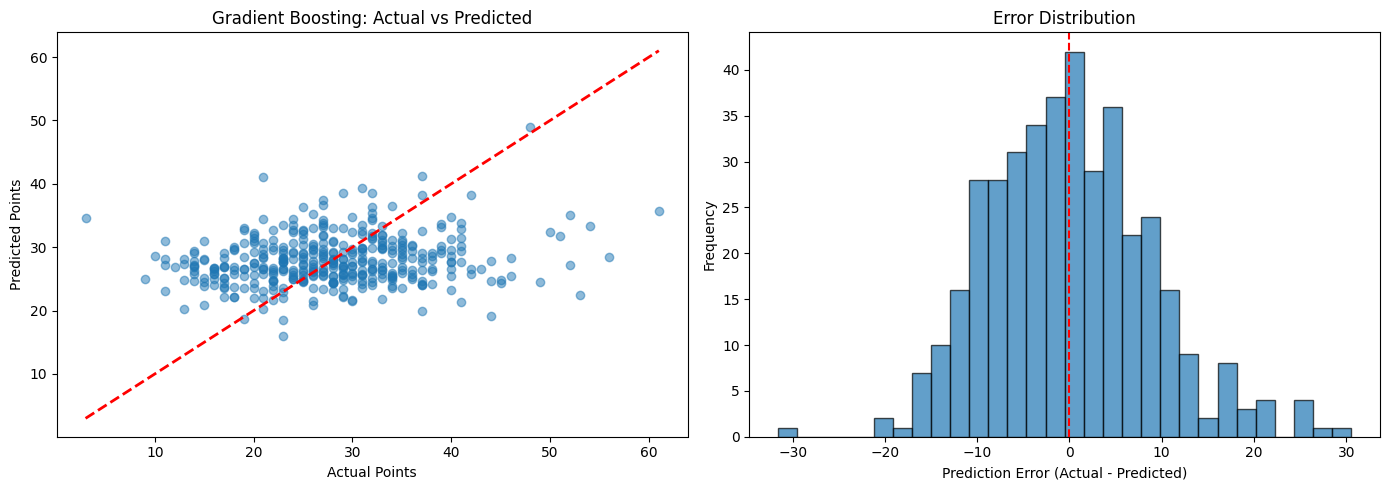


Mean Error: 0.00
Error Std: 8.85


In [90]:
# Plot actual vs predicted for best model
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scatter plot
axes[0].scatter(y_test, y_pred_gb, alpha=0.5)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual Points')
axes[0].set_ylabel('Predicted Points')
axes[0].set_title('Gradient Boosting: Actual vs Predicted')

# Error distribution
errors = y_test - y_pred_gb
axes[1].hist(errors, bins=30, edgecolor='black', alpha=0.7)
axes[1].axvline(x=0, color='red', linestyle='--')
axes[1].set_xlabel('Prediction Error (Actual - Predicted)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Error Distribution')

plt.tight_layout()
plt.show()

print(f"\nMean Error: {errors.mean():.2f}")
print(f"Error Std: {errors.std():.2f}")

# Model needs improvement

In [91]:
# Reload and add player encoding
df = pd.read_csv("data/processed/player_game_logs_featured.csv")
df['GAME_DATE'] = pd.to_datetime(df['GAME_DATE'])
df = df.sort_values('GAME_DATE').reset_index(drop=True)

# Create player average points (their baseline)
player_avg = df.groupby('Player_ID')['PTS'].mean()
df['PLAYER_AVG_PTS'] = df['Player_ID'].map(player_avg)

# Updated feature list
feature_cols_v2 = [
    'HOME',
    'REST_DAYS',
    'B2B',
    'ROLL_PTS_3',
    'ROLL_PTS_5',
    'ROLL_PTS_10',
    'SEASON_AVG_PTS',
    'PLAYER_AVG_PTS'  # NEW
]

print("=== PLAYER AVERAGES ===")
print(df.groupby('Player_ID')['PLAYER_AVG_PTS'].first().sort_values(ascending=False))

=== PLAYER AVERAGES ===
Player_ID
203954     32.349593
1629029    32.081522
1628983    31.383562
203507     30.900498
1628369    27.927273
201142     27.418478
203999     26.816514
201939     26.610000
1630162    26.229787
2544       26.132653
Name: PLAYER_AVG_PTS, dtype: float64


In [92]:
# Prepare data
X = df[feature_cols_v2]
y = df['PTS']

# Time-based split
split_index = int(len(df) * 0.8)
X_train = X.iloc[:split_index]
X_test = X.iloc[split_index:]
y_train = y.iloc[:split_index]
y_test = y.iloc[split_index:]

# Train Ridge (best performer)
ridge_v2 = Ridge(alpha=1.0)
ridge_v2.fit(X_train, y_train)
y_pred_v2 = ridge_v2.predict(X_test)

# Evaluate
mae_v2 = mean_absolute_error(y_test, y_pred_v2)
rmse_v2 = np.sqrt(mean_squared_error(y_test, y_pred_v2))
r2_v2 = r2_score(y_test, y_pred_v2)

print("=== IMPROVED MODEL RESULTS ===")
print(f"MAE:  {mae_v2:.2f} points (was 6.70)")
print(f"RMSE: {rmse_v2:.2f} points (was 8.53)")
print(f"R²:   {r2_v2:.3f} (was 0.035)")

=== IMPROVED MODEL RESULTS ===
MAE:  6.63 points (was 6.70)
RMSE: 8.56 points (was 8.53)
R²:   0.029 (was 0.035)


In [93]:
# Which features matter now?
coefficients = pd.DataFrame({
    'Feature': feature_cols_v2,
    'Coefficient': ridge_v2.coef_
}).sort_values('Coefficient', key=abs, ascending=False)

print("=== FEATURE IMPORTANCE ===")
print(coefficients)

=== FEATURE IMPORTANCE ===
          Feature  Coefficient
7  PLAYER_AVG_PTS     0.781392
0            HOME     0.357167
1       REST_DAYS    -0.253584
6  SEASON_AVG_PTS     0.228070
5     ROLL_PTS_10     0.178201
2             B2B    -0.147980
4      ROLL_PTS_5    -0.057943
3      ROLL_PTS_3    -0.051004


## Adding Opponent Defense Stats (12 and beyond)

In [94]:
# Extract opponent team from MATCHUP
# "BOS vs. MIA" → "MIA"
# "BOS @ MIA" → "MIA"

def extract_opponent(matchup):
    if ' vs. ' in matchup:
        return matchup.split(' vs. ')[1]
    elif ' @ ' in matchup:
        return matchup.split(' @ ')[1]
    return None

df['OPPONENT'] = df['MATCHUP'].apply(extract_opponent)

print("=== OPPONENTS ===")
print(df['OPPONENT'].value_counts().head(10))

=== OPPONENTS ===
OPPONENT
HOU    81
LAC    79
POR    78
SAS    75
SAC    75
DAL    75
UTA    74
MEM    74
NOP    73
DEN    73
Name: count, dtype: int64


In [95]:
from nba_api.stats.static import teams as nba_teams

# Get team name to abbreviation mapping
def get_team_abbreviation_map():
    """Create mapping from team name to abbreviation."""
    team_list = nba_teams.get_teams()
    return {team['full_name']: team['abbreviation'] for team in team_list}

team_abbrev_map = get_team_abbreviation_map()

print("=== TEAM MAPPING (sample) ===")
for name, abbr in list(team_abbrev_map.items())[:5]:
    print(f"  {name} → {abbr}")

=== TEAM MAPPING (sample) ===
  Atlanta Hawks → ATL
  Boston Celtics → BOS
  Cleveland Cavaliers → CLE
  New Orleans Pelicans → NOP
  Chicago Bulls → CHI


In [96]:
def get_team_defensive_proxy(season):
    """
    Create defensive strength proxy using PLUS_MINUS.
    
    Lower PLUS_MINUS = worse defense = easier to score against
    We invert it so higher = weaker opponent
    """
    try:
        stats = leaguedashteamstats.LeagueDashTeamStats(
            season=season,
            per_mode_detailed='PerGame'
        )
        df_stats = stats.get_data_frames()[0]
        
        # Add abbreviation using mapping
        df_stats['TEAM_ABBREVIATION'] = df_stats['TEAM_NAME'].map(team_abbrev_map)
        
        # Invert PLUS_MINUS: negative = bad defense = easier to score against
        df_stats['OPP_DEF_RATING'] = -df_stats['PLUS_MINUS']
        
        df_stats['SEASON'] = season
        
        return df_stats[['TEAM_ABBREVIATION', 'OPP_DEF_RATING', 'SEASON']]
        
    except Exception as e:
        print(f"{season} failed: {e}")
        return None

# Pull for all seasons
seasons = ['2022-23', '2023-24', '2024-25']
all_ratings = []

for season in seasons:
    print(f"Pulling {season}...")
    ratings = get_team_defensive_proxy(season)
    
    if ratings is not None:
        all_ratings.append(ratings)
        print(f"  Got {len(ratings)} teams")
    
    time.sleep(1)

# Combine
team_ratings = pd.concat(all_ratings, ignore_index=True)

print("\n=== TEAM DEFENSIVE RATINGS ===")
print(team_ratings.sort_values('OPP_DEF_RATING', ascending=False).head(10))

Pulling 2022-23...
  Got 30 teams
Pulling 2023-24...
  Got 30 teams
Pulling 2024-25...
  Got 30 teams

=== TEAM DEFENSIVE RATINGS ===
   TEAM_ABBREVIATION  OPP_DEF_RATING   SEASON
89               WAS            12.4  2024-25
33               CHA            10.2  2023-24
26               SAS            10.0  2022-23
78               NOP             9.4  2024-25
88               UTA             9.3  2024-25
59               WAS             9.3  2023-24
63               CHA             9.1  2024-25
38               DET             9.1  2023-24
54               POR             9.0  2023-24
8                DET             8.2  2022-23


In [97]:
# Create mapping: (team abbreviation, season) → defensive rating
def_rating_map = team_ratings.set_index(['TEAM_ABBREVIATION', 'SEASON'])['OPP_DEF_RATING'].to_dict()

# Apply to dataframe
df['OPP_DEF_RATING'] = df.apply(
    lambda row: def_rating_map.get((row['OPPONENT'], row['SEASON']), None),
    axis=1
)

# Check coverage
print("=== OPPONENT DEFENSIVE RATING ===")
print(f"Games with rating: {df['OPP_DEF_RATING'].notna().sum()}")
print(f"Games missing: {df['OPP_DEF_RATING'].isna().sum()}")
print(f"\nRating range: {df['OPP_DEF_RATING'].min():.1f} to {df['OPP_DEF_RATING'].max():.1f}")

=== OPPONENT DEFENSIVE RATING ===
Games with rating: 1901
Games missing: 79

Rating range: -12.9 to 12.4


In [98]:
# Fill missing with league average
league_avg_def = df['OPP_DEF_RATING'].mean()
df['OPP_DEF_RATING'] = df['OPP_DEF_RATING'].fillna(league_avg_def)

# Simplified feature set
feature_cols_v3 = [
    'HOME',
    'REST_DAYS',
    'B2B',
    'ROLL_PTS_5',
    'SEASON_AVG_PTS',
    'OPP_DEF_RATING'
]

# Prepare data
X = df[feature_cols_v3]
y = df['PTS']

# Time-based split
df = df.sort_values('GAME_DATE').reset_index(drop=True)
X = df[feature_cols_v3]
y = df['PTS']

split_index = int(len(df) * 0.8)
X_train = X.iloc[:split_index]
X_test = X.iloc[split_index:]
y_train = y.iloc[:split_index]
y_test = y.iloc[split_index:]

print(f"Training: {len(X_train)} games")
print(f"Test: {len(X_test)} games")
print(f"\nFeatures: {feature_cols_v3}")

Training: 1584 games
Test: 396 games

Features: ['HOME', 'REST_DAYS', 'B2B', 'ROLL_PTS_5', 'SEASON_AVG_PTS', 'OPP_DEF_RATING']


In [99]:
# Train multiple models
models = {
    'Ridge': Ridge(alpha=1.0),
    'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=6, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, max_depth=4, random_state=42)
}

results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    results.append({
        'Model': name,
        'MAE': mae,
        'RMSE': rmse,
        'R²': r2
    })
    
    print(f"{name}: MAE={mae:.2f}, R²={r2:.3f}")

results_df = pd.DataFrame(results).sort_values('MAE')

print("\n=== MODEL COMPARISON (with Opponent Defense) ===")
print(results_df.to_string(index=False))

Ridge: MAE=6.62, R²=0.046
Random Forest: MAE=6.71, R²=0.018
Gradient Boosting: MAE=7.04, R²=-0.059

=== MODEL COMPARISON (with Opponent Defense) ===
            Model      MAE     RMSE        R²
            Ridge 6.621426 8.486931  0.045540
    Random Forest 6.705159 8.609014  0.017884
Gradient Boosting 7.041896 8.938508 -0.058732


In [100]:
# Get best model (lowest MAE)
best_model_name = results_df.iloc[0]['Model']
best_model = models[best_model_name]

print(f"=== FEATURE IMPORTANCE ({best_model_name}) ===")

if best_model_name == 'Ridge':
    importance = pd.DataFrame({
        'Feature': feature_cols_v3,
        'Coefficient': best_model.coef_
    }).sort_values('Coefficient', key=abs, ascending=False)
else:
    importance = pd.DataFrame({
        'Feature': feature_cols_v3,
        'Importance': best_model.feature_importances_
    }).sort_values('Importance', ascending=False)

print(importance)

=== FEATURE IMPORTANCE (Ridge) ===
          Feature  Coefficient
4  SEASON_AVG_PTS     0.599864
0            HOME     0.408839
2             B2B    -0.302861
1       REST_DAYS    -0.198223
5  OPP_DEF_RATING     0.072729
3      ROLL_PTS_5     0.039765


### Saving the Model

In [101]:
import pickle

# Save the best model (Ridge)
best_model = Ridge(alpha=1.0)
best_model.fit(X_train, y_train)

# Save model
with open('src/models/ridge_pts_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

# Save feature columns (important for predictions)
with open('src/models/feature_cols.pkl', 'wb') as f:
    pickle.dump(feature_cols_v3, f)

print("Model saved ✓")
print("Feature columns saved ✓")
print(f"\nFeatures: {feature_cols_v3}")

Model saved ✓
Feature columns saved ✓

Features: ['HOME', 'REST_DAYS', 'B2B', 'ROLL_PTS_5', 'SEASON_AVG_PTS', 'OPP_DEF_RATING']


In [102]:
def predict_points(
    player_name,
    opponent,
    home,
    rest_days,
    roll_pts_5,
    season_avg_pts,
    opp_def_rating=None
):
    """
    Predict points for a player in an upcoming game.
    
    Parameters:
    -----------
    player_name : str
        For display purposes
    opponent : str
        Team abbreviation (e.g., 'MIA')
    home : int
        1 = home, 0 = away
    rest_days : int
        Days since last game (cap at 7)
    roll_pts_5 : float
        Average of last 5 games
    season_avg_pts : float
        Season average
    opp_def_rating : float (optional)
        Opponent defensive rating (if None, uses league avg)
    
    Returns:
    --------
    Predicted points
    """
    # Load model
    with open('src/models/ridge_pts_model.pkl', 'rb') as f:
        model = pickle.load(f)
    
    # Handle opponent defensive rating
    if opp_def_rating is None:
        opp_def_rating = 0  # League average (neutral)
    
    # Back-to-back flag
    b2b = 1 if rest_days == 1 else 0
    
    # Cap rest days
    rest_days = min(rest_days, 7)
    
    # Create feature array
    features = pd.DataFrame([{
        'HOME': home,
        'REST_DAYS': rest_days,
        'B2B': b2b,
        'ROLL_PTS_5': roll_pts_5,
        'SEASON_AVG_PTS': season_avg_pts,
        'OPP_DEF_RATING': opp_def_rating
    }])
    
    # Predict
    prediction = model.predict(features)[0]
    
    print(f"\n{'='*40}")
    print(f"PREDICTION: {player_name}")
    print(f"{'='*40}")
    print(f"Opponent: {opponent} ({'Home' if home else 'Away'})")
    print(f"Rest days: {rest_days} ({'B2B' if b2b else 'Normal rest'})")
    print(f"Last 5 avg: {roll_pts_5:.1f}")
    print(f"Season avg: {season_avg_pts:.1f}")
    print(f"Opp defense: {opp_def_rating:+.1f}")
    print(f"{'='*40}")
    print(f"PREDICTED POINTS: {prediction:.1f}")
    print(f"{'='*40}")
    
    return prediction

print("Prediction function created ✓")

Prediction function created ✓


In [103]:
# Create a quick reference for opponent ratings
current_ratings = team_ratings[team_ratings['SEASON'] == '2024-25'].copy()
current_ratings = current_ratings.sort_values('OPP_DEF_RATING', ascending=False)

print("=== 2024-25 OPPONENT RATINGS ===")
print("(Higher = weaker defense = easier to score)")
print(current_ratings.to_string(index=False))

=== 2024-25 OPPONENT RATINGS ===
(Higher = weaker defense = easier to score)
TEAM_ABBREVIATION  OPP_DEF_RATING  SEASON
              WAS            12.4 2024-25
              NOP             9.4 2024-25
              UTA             9.3 2024-25
              CHA             9.1 2024-25
              BKN             7.1 2024-25
              PHI             6.2 2024-25
              TOR             4.3 2024-25
              POR             3.0 2024-25
              PHX             3.0 2024-25
              SAS             2.8 2024-25
              CHI             1.6 2024-25
              DAL             1.2 2024-25
              ATL             1.1 2024-25
              ORL             0.1 2024-25
              SAC            -0.5 2024-25
              MIA            -0.6 2024-25
              LAL            -1.2 2024-25
              DET            -1.9 2024-25
              IND            -2.2 2024-25
              MIL            -2.5 2024-25
              GSW            -3.3 2024-25

In [104]:
# Example: Predict Jayson Tatum tonight

predict_points(
    player_name="Jayson Tatum",
    opponent="MIA",
    home=1,                    # Home game
    rest_days=2,               # 2 days rest
    roll_pts_5=28.4,           # Last 5 game average
    season_avg_pts=27.8,       # Season average
    opp_def_rating=2.5         # Miami's rating (check from Step 21)
)


PREDICTION: Jayson Tatum
Opponent: MIA (Home)
Rest days: 2 (Normal rest)
Last 5 avg: 28.4
Season avg: 27.8
Opp defense: +2.5
PREDICTED POINTS: 28.7


np.float64(28.65558543284237)

In [105]:
def predict_slate(predictions_input):
    """
    Predict points for multiple players.
    
    Parameters:
    -----------
    predictions_input : list of dicts
        Each dict contains player info
    
    Returns:
    --------
    DataFrame with predictions
    """
    with open('src/models/ridge_pts_model.pkl', 'rb') as f:
        model = pickle.load(f)
    
    results = []
    
    for p in predictions_input:
        b2b = 1 if p['rest_days'] == 1 else 0
        rest_days = min(p['rest_days'], 7)
        opp_def = p.get('opp_def_rating', 0)
        
        features = pd.DataFrame([{
            'HOME': p['home'],
            'REST_DAYS': rest_days,
            'B2B': b2b,
            'ROLL_PTS_5': p['roll_pts_5'],
            'SEASON_AVG_PTS': p['season_avg_pts'],
            'OPP_DEF_RATING': opp_def
        }])
        
        pred = model.predict(features)[0]
        
        results.append({
            'Player': p['player_name'],
            'Opponent': p['opponent'],
            'Home': 'Yes' if p['home'] else 'No',
            'Predicted PTS': round(pred, 1)
        })
    
    return pd.DataFrame(results)


# Example slate
slate = [
    {
        'player_name': 'Jayson Tatum',
        'opponent': 'MIA',
        'home': 1,
        'rest_days': 2,
        'roll_pts_5': 28.4,
        'season_avg_pts': 27.8,
        'opp_def_rating': 2.5
    },
    {
        'player_name': 'Luka Dončić',
        'opponent': 'HOU',
        'home': 0,
        'rest_days': 1,
        'roll_pts_5': 32.1,
        'season_avg_pts': 33.2,
        'opp_def_rating': 1.2
    },
    {
        'player_name': 'Shai Gilgeous-Alexander',
        'opponent': 'POR',
        'home': 1,
        'rest_days': 3,
        'roll_pts_5': 31.5,
        'season_avg_pts': 31.8,
        'opp_def_rating': 5.8
    }
]

print("=== TONIGHT'S SLATE PREDICTIONS ===")
print(predict_slate(slate))

=== TONIGHT'S SLATE PREDICTIONS ===
                    Player Opponent Home  Predicted PTS
0             Jayson Tatum      MIA  Yes           28.7
1              Luka Dončić      HOU   No           31.4
2  Shai Gilgeous-Alexander      POR  Yes           31.2


In [106]:
# Save team ratings for quick lookup
team_ratings.to_csv('data/external/team_defensive_ratings.csv', index=False)

# Save the cleaned featured dataset
df.to_csv('data/processed/player_game_logs_featured.csv', index=False)

print("All data saved ✓")
print("\nFiles:")
print("  - src/models/ridge_pts_model.pkl")
print("  - src/models/feature_cols.pkl")
print("  - data/external/team_defensive_ratings.csv")
print("  - data/processed/player_game_logs_featured.csv")

All data saved ✓

Files:
  - src/models/ridge_pts_model.pkl
  - src/models/feature_cols.pkl
  - data/external/team_defensive_ratings.csv
  - data/processed/player_game_logs_featured.csv


# Smart Prediction Function
The model will:

1. Look up player's latest stats automatically
2. Look up opponent defensive rating automatically
3. You only input: player name + opponent + home/away

In [107]:
# Create player stats lookup from our dataset
def get_player_latest_stats(player_id, df):
    """
    Get player's most recent stats from our dataset.
    
    Returns: roll_pts_5, season_avg_pts, last_game_date
    """
    player_df = df[df['Player_ID'] == player_id].sort_values('GAME_DATE')
    
    if player_df.empty:
        return None
    
    latest = player_df.iloc[-1]
    
    return {
        'roll_pts_5': latest['ROLL_PTS_5'],
        'season_avg_pts': latest['SEASON_AVG_PTS'],
        'last_game_date': latest['GAME_DATE']
    }

# Create player name to ID mapping
def build_player_lookup(df):
    """Build player name → ID mapping."""
    player_ids = df['Player_ID'].unique()
    
    player_lookup = {}
    for pid in player_ids:
        player_list = players.get_players()
        player = [p for p in player_list if p['id'] == pid]
        if player:
            player_lookup[player[0]['full_name'].lower()] = pid
    
    return player_lookup

player_lookup = build_player_lookup(df)

print("=== PLAYERS AVAILABLE ===")
for name in player_lookup.keys():
    print(f"  • {name.title()}") 

=== PLAYERS AVAILABLE ===
  • Jayson Tatum
  • Joel Embiid
  • Lebron James
  • Stephen Curry
  • Kevin Durant
  • Luka Dončić
  • Nikola Jokić
  • Shai Gilgeous-Alexander
  • Anthony Edwards
  • Giannis Antetokounmpo


In [108]:
# Load team ratings
team_ratings_df = pd.read_csv('data/external/team_defensive_ratings.csv')

# Get current season ratings
current_season = '2024-25'
current_ratings = team_ratings_df[team_ratings_df['SEASON'] == current_season]

# Create opponent → rating lookup
opp_rating_lookup = current_ratings.set_index('TEAM_ABBREVIATION')['OPP_DEF_RATING'].to_dict()

print("=== OPPONENT RATINGS (2024-25) ===")
for team, rating in sorted(opp_rating_lookup.items(), key=lambda x: x[1], reverse=True):
    print(f"  {team}: {rating:+.1f}")

=== OPPONENT RATINGS (2024-25) ===
  WAS: +12.4
  NOP: +9.4
  UTA: +9.3
  CHA: +9.1
  BKN: +7.1
  PHI: +6.2
  TOR: +4.3
  PHX: +3.0
  POR: +3.0
  SAS: +2.8
  CHI: +1.6
  DAL: +1.2
  ATL: +1.1
  ORL: +0.1
  SAC: -0.5
  MIA: -0.6
  LAL: -1.2
  DET: -1.9
  IND: -2.2
  MIL: -2.5
  GSW: -3.3
  DEN: -3.9
  NYK: -4.1
  HOU: -4.5
  nan: -4.7
  MEM: -4.9
  MIN: -5.0
  BOS: -9.1
  CLE: -9.5
  OKC: -12.9


In [109]:
def smart_predict(player_name, opponent, home, rest_days=None):
    """
    Predict points with minimal input.
    
    Parameters:
    -----------
    player_name : str
        Player's full name (e.g., "Jayson Tatum")
    opponent : str
        Team abbreviation (e.g., "MIA")
    home : int
        1 = home, 0 = away
    rest_days : int (optional)
        Days since last game. If None, assumes 2 days.
    
    Returns:
    --------
    Predicted points
    """
    # Load model
    with open('src/models/ridge_pts_model.pkl', 'rb') as f:
        model = pickle.load(f)
    
    # Load data
    df = pd.read_csv('data/processed/player_game_logs_featured.csv')
    df['GAME_DATE'] = pd.to_datetime(df['GAME_DATE'])
    
    # Find player ID
    player_key = player_name.lower()
    if player_key not in player_lookup:
        print(f"❌ Player '{player_name}' not found.")
        print(f"Available players:")
        for name in player_lookup.keys():
            print(f"  • {name.title()}")
        return None
    
    player_id = player_lookup[player_key]
    
    # Get player's latest stats
    player_stats = get_player_latest_stats(player_id, df)
    if player_stats is None:
        print(f"❌ No data found for {player_name}")
        return None
    
    # Get opponent defensive rating
    opponent = opponent.upper()
    if opponent not in opp_rating_lookup:
        print(f"⚠️ Opponent '{opponent}' not found. Using league average.")
        opp_def_rating = 0
    else:
        opp_def_rating = opp_rating_lookup[opponent]
    
    # Default rest days
    if rest_days is None:
        rest_days = 2
    
    # Back-to-back flag
    b2b = 1 if rest_days == 1 else 0
    rest_days = min(rest_days, 7)
    
    # Create features
    features = pd.DataFrame([{
        'HOME': home,
        'REST_DAYS': rest_days,
        'B2B': b2b,
        'ROLL_PTS_5': player_stats['roll_pts_5'],
        'SEASON_AVG_PTS': player_stats['season_avg_pts'],
        'OPP_DEF_RATING': opp_def_rating
    }])
    
    # Predict
    prediction = model.predict(features)[0]
    
    # Display results
    print(f"\n{'='*45}")
    print(f"  PREDICTION: {player_name.upper()}")
    print(f"{'='*45}")
    print(f"  Opponent:      {opponent} ({'Home' if home else 'Away'})")
    print(f"  Rest days:     {rest_days} ({'B2B ⚠️' if b2b else 'Normal'})")
    print(f"  Last 5 avg:    {player_stats['roll_pts_5']:.1f}")
    print(f"  Season avg:    {player_stats['season_avg_pts']:.1f}")
    print(f"  Opp defense:   {opp_def_rating:+.1f}")
    print(f"{'='*45}")
    print(f"  📊 PREDICTED POINTS: {prediction:.1f}")
    print(f"{'='*45}\n")
    
    return prediction

print("Smart prediction function created ✓")

Smart prediction function created ✓


In [110]:
# Now you only need: player name, opponent, home/away

# Example 1: Tatum at home vs Miami
smart_predict("Jayson Tatum", "MIA", home=1)

# Example 2: Luka on the road vs Lakers (back-to-back)
smart_predict("Luka Dončić", "LAL", home=0, rest_days=1)

# Example 3: SGA at home vs Portland
smart_predict("Shai Gilgeous-Alexander", "POR", home=1)


  PREDICTION: JAYSON TATUM
  Opponent:      MIA (Home)
  Rest days:     2 (Normal)
  Last 5 avg:    25.0
  Season avg:    27.0
  Opp defense:   -0.6
  📊 PREDICTED POINTS: 27.8


  PREDICTION: LUKA DONČIĆ
  Opponent:      LAL (Away)
  Rest days:     1 (B2B ⚠️)
  Last 5 avg:    30.4
  Season avg:    27.9
  Opp defense:   -1.2
  📊 PREDICTED POINTS: 28.0


  PREDICTION: SHAI GILGEOUS-ALEXANDER
  Opponent:      POR (Home)
  Rest days:     2 (Normal)
  Last 5 avg:    28.2
  Season avg:    32.6
  Opp defense:   +3.0
  📊 PREDICTED POINTS: 31.5



np.float64(31.53934785678569)

In [111]:
def smart_predict_slate(slate):
    """
    Predict for multiple players.
    
    Parameters:
    -----------
    slate : list of tuples
        Each tuple: (player_name, opponent, home, rest_days)
        rest_days is optional
    
    Returns:
    --------
    DataFrame with predictions
    """
    with open('src/models/ridge_pts_model.pkl', 'rb') as f:
        model = pickle.load(f)
    
    df = pd.read_csv('data/processed/player_game_logs_featured.csv')
    df['GAME_DATE'] = pd.to_datetime(df['GAME_DATE'])
    
    results = []
    
    for entry in slate:
        # Parse input
        player_name = entry[0]
        opponent = entry[1].upper()
        home = entry[2]
        rest_days = entry[3] if len(entry) > 3 else 2
        
        # Get player ID
        player_key = player_name.lower()
        if player_key not in player_lookup:
            continue
        
        player_id = player_lookup[player_key]
        player_stats = get_player_latest_stats(player_id, df)
        
        if player_stats is None:
            continue
        
        # Get opponent rating
        opp_def_rating = opp_rating_lookup.get(opponent, 0)
        
        # Create features
        b2b = 1 if rest_days == 1 else 0
        
        features = pd.DataFrame([{
            'HOME': home,
            'REST_DAYS': min(rest_days, 7),
            'B2B': b2b,
            'ROLL_PTS_5': player_stats['roll_pts_5'],
            'SEASON_AVG_PTS': player_stats['season_avg_pts'],
            'OPP_DEF_RATING': opp_def_rating
        }])
        
        pred = model.predict(features)[0]
        
        results.append({
            'Player': player_name,
            'Opponent': opponent,
            'Home': '🏠' if home else '✈️',
            'Last 5': round(player_stats['roll_pts_5'], 1),
            'Season': round(player_stats['season_avg_pts'], 1),
            'Predicted': round(pred, 1)
        })
    
    return pd.DataFrame(results)


# Example usage - just player, opponent, home/away
slate = [
    ("Jayson Tatum", "MIA", 1),
    ("Luka Dončić", "LAL", 0, 1),       # With rest_days
    ("LeBron James", "BOS", 0),
    ("Stephen Curry", "NYK", 1),
    ("Joel Embiid", "CHI", 1)
]

print("=== TONIGHT'S SLATE ===")
print(smart_predict_slate(slate))

=== TONIGHT'S SLATE ===
          Player Opponent Home  Last 5  Season  Predicted
0   Jayson Tatum      MIA    🏠    25.0    27.0       27.8
1    Luka Dončić      LAL   ✈️    30.4    27.9       28.0
2   LeBron James      BOS   ✈️    26.8    24.6       25.4
3  Stephen Curry      NYK    🏠    21.6    24.4       25.9
4    Joel Embiid      CHI    🏠    24.2    25.2       26.9


## Now lets add more players

In [ ]:
# Expanded list: Top 50 scorers
PLAYERS_EXPANDED = [
    # Already have these 10
    "Jayson Tatum",
    "Luka Dončić",
    "Shai Gilgeous-Alexander",
    "Giannis Antetokounmpo",
    "Joel Embiid",
    "Nikola Jokić",
    "Kevin Durant",
    "LeBron James",
    "Stephen Curry",
    "Anthony Edwards",
    
    # Adding 40 more
    "Donovan Mitchell",
    "Devin Booker",
    "Kyrie Irving",
    "Damian Lillard",
    "Trae Young",
    "Zion Williamson",
    "De'Aaron Fox",
    "Ja Morant",
    "Tyrese Haliburton",
    "Paolo Banchero",
    "LaMelo Ball",
    "Jalen Brunson",
    "Domantas Sabonis",
    "Tyrese Maxey",
    "Scottie Barnes",
    "Cade Cunningham",
    "Desmond Bane",
    "CJ McCollum",
    "Brandon Ingram",
    "Zach LaVine",
    "Julius Randle",
    "Karl-Anthony Towns",
    "Bam Adebayo",
    "Pascal Siakam",
    "Mikal Bridges",
    "Dejounte Murray",
    "Fred VanVleet",
    "Anfernee Simons",
    "Jalen Williams",
    "Franz Wagner",
    "Tyler Herro",
    "Lauri Markkanen",
    "Jaren Jackson Jr.",
    "Anthony Davis",
    "Kawhi Leonard",
    "Paul George",
    "Jimmy Butler",
    "Khris Middleton",
    "Bradley Beal",
    "Derrick White",
    "RJ Barrett", 
    "Kristaps Porziņģis"
]

print(f"Total players to pull: {len(PLAYERS_EXPANDED)}")
print(f"Already have: 10")
print(f"New players: {len(PLAYERS_EXPANDED) - 10}")